# Argon Emission Spectrum
Predicting the emission spectrum of Argon LSP to determine the plasma temperature

## Analysis of Xenon spectrum
Comparing the emission lines of Xenon to the LSP spectrum measured by Zimakov et al. [1]

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


def pullEmissionLineData(specie):
    cachePath = '../cachedata/{}Spectrum.csv'.format(specie)
    try:
        lines = pd.read_html(  # This fails sometimes...
            'https://physics.nist.gov/PhysRefData/Handbook/Tables/{}table2.htm'.format(
                specie
            ),
            match='Air'
            )[1]
        # Some cleanup
        lines.dropna(axis=0, how='all', inplace=True)
        lines.dropna(axis=1, how='all', inplace=True)
        lines['Intensity'] = lines['Intensity'].map(
            lambda s: s.rstrip(' Phls'))
        lines['Intensity'] = pd.to_numeric(lines['Intensity'])
        lines.to_csv(cachePath)
    except:
        print('Warning - {}: Could not access data from NIST, falling back to cache...'.format(specie))
        lines = pd.read_csv(cachePath, index_col=0)
    return lines

argonLines = pullEmissionLineData('argon')
xenonLines = pullEmissionLineData('xenon')

Warning - argon: Could not access data from NIST, falling back to cache...
Warning - xenon: Could not access data from NIST, falling back to cache...


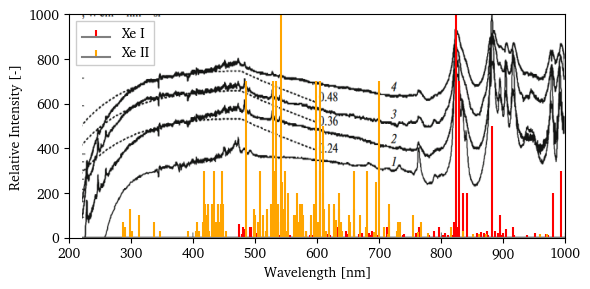

In [7]:
xenonLines['Wavelength [nm]'] = xenonLines['Air Wavelength (Å)']/10
XeILines = xenonLines[xenonLines['Spectrum'] == 'Xe I']
XeIILines = xenonLines[xenonLines['Spectrum'] == 'Xe II']
# ArILines = argonLines[argonLines['Spectrum'] == 'Ar I']
# ArIILines = argonLines[argonLines['Spectrum'] == 'Ar II']

zimakovData = np.asarray(Image.open('../rawdata/zimakov.png'))
plt.imshow(zimakovData, extent=(220, 1000, 0, 1000))
# plt.stem(ArILines['Wavelength [nm]'], ArILines['Intensity'], label='Ar I',
#          linefmt='red', markerfmt='', basefmt='grey')
# plt.stem(ArIILines['Wavelength [nm]'], ArIILines['Intensity'], label='Ar II',
#          linefmt='orange', markerfmt='', basefmt='grey')
plt.stem(XeILines['Wavelength [nm]'], XeILines['Intensity'], label='Xe I',
         linefmt='red', markerfmt='', basefmt='grey')
plt.stem(XeIILines['Wavelength [nm]'], XeIILines['Intensity'], label='Xe II',
         linefmt='orange', markerfmt='', basefmt='grey')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Intensity [-]')
plt.xlim(200, 1000)
ax = plt.gca()
ax.set_aspect(265/736)
plt.legend(loc='upper left')
plt.show()

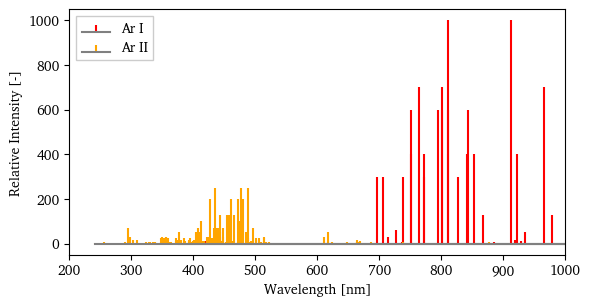

In [8]:
argonLines['Wavelength [nm]'] = argonLines['Air Wavelength (Å)']/10
ArILines = argonLines[argonLines['Spectrum'] == 'Ar I']
ArIILines = argonLines[argonLines['Spectrum'] == 'Ar II']

plt.stem(ArILines['Wavelength [nm]'], ArILines['Intensity'], label='Ar I',
         linefmt='red', markerfmt='', basefmt='grey')
plt.stem(ArIILines['Wavelength [nm]'], ArIILines['Intensity'], label='Ar II',
         linefmt='orange', markerfmt='', basefmt='grey')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Intensity [-]')
plt.xlim(200, 1000)
ax = plt.gca()
ax.set_aspect(265/736)
plt.legend(loc='upper left')
plt.show()

## Calculation of Xenon spectrum in the UV
Using the method presented in [2]:
$$
    \epsilon_\nu = 5.44\times10^{-39}\frac{n_\mathrm{e}n_+}{T^{1/2}}\exp{\left(\frac{-\Delta I}{kT}\right)}\xi(\nu)\exp{\left(\frac{h(\nu_g-\nu)}{kT}\right)}\;\left[\frac{\mathrm{W}}{\mathrm{cm}^2\:\mathrm{nm}\:\mathrm{sr}}\mathrm{???}\right]
$$
With
$$
    \Delta I = \frac{1.4\mathrm{e}^2}{\lambda_D}
$$

## References
[1] Zimakov, V.P., Kuznetsov, V.A., Solovyov, N.G. et al. [Interaction of near-IR laser radiation with plasma of a continuous optical discharge](https://doi.org/10.1134/S1063780X15110100). Plasma Phys. Rep. 42, 68–73 (2016). DOI: 10.1134/S1063780X15110100  
[2] Kozlov, G I, Kuznetsov, V A, & Masyukov, V A. [Radiative losses from an argon plasma and a radiation model of a continuous optical discharge.](http://www.jetp.ras.ru/cgi-bin/dn/e_039_03_0463.pdf) Zh. Eksp. Teor. Fiz. 66, 954-964 (1974)